# Machine Learning Coursework 2
 
#### Author: 200590440
#### Date: 2022-03-26
#### Github repo: https://github.com/jm-training/DSM040-CW2
#### Contents:

0. Set up Python packages and libraries


1. Classifiers
       a. Get data
       b. Exploratory data analysis
       c. Create training and test data for model builds
       d. Build model evaluation functions
       e. Naïve Bayes Classifier
       f. Random Forest Classifier
       g. kNN Classifier
       
2. Code report


3. Model questions
       3.1 Naïves Bayes questions
       3.2 Random Forest questions
       3.3 kNN questions
       
4. Comparing models
       4.1 Compare each model
       4.2 Accuracy
       4.3 Appropriate use
       
5. References


6. Requirements file

#### Notes:
a. I have removed the instructions to avoid a high similarity score on turnitin

b. As per requirements file users will have to install shap and ipympl packages

## 0. Set up Python packages and libraries

In [2]:
# Install packages (run once only)
#!pip install shap
#!pip install ipympl

In [4]:
# Install libraries
import pandas as pd
import numpy as np
from sklearn import datasets, naive_bayes
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
import seaborn as sb
import matplotlib.pyplot as plt
import shap

## 1. Classifiers [7 marks total]

### a. Get data

Here I have chosen to load the data into a dataframe which is much easier to use and manipulate than when dealing with separate arrays and lists

In [5]:
iris = datasets.load_iris()

# Review the dataset meta data
#print(iris.DESCR) 

Key findings:
- 150 cases (50 per target class)
- 4 features (all numeric)
- 1 target comprising 3 classes
    - 0 = Setosa
    - 1 = Versicolour
    - 2 = Virginica

In [6]:
# Convert data into a pandas dataframe for ease of use
df=pd.DataFrame(iris['data'], columns=['sepal_length','sepal_width','petal_length','petal_width']) 
df['species']=iris['target']

# Add species name for presentation purposes
def assign(x):
    if x==0:
        return 'Setosa'
    elif x==1:
        return 'Versicolour'
    elif x==2:
        return 'Virginica'
    else:
        return 'Unknown'

df['species_name']=df.apply(lambda row: assign(row['species']), axis=1)

In [7]:
# Check labelling
df.groupby(["species_name","species"])["species"].count()

species_name  species
Setosa        0          50
Versicolour   1          50
Virginica     2          50
Name: species, dtype: int64

In [8]:
# Check size of dataframe
df.shape

(150, 6)

### b. Exploratory data analysis

Here I quickly review the data for its structure, quality and feature relationships to provide insight ahead of modelling 

In [9]:
# Eyeball data
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species,species_name
0,5.1,3.5,1.4,0.2,0,Setosa
1,4.9,3.0,1.4,0.2,0,Setosa
2,4.7,3.2,1.3,0.2,0,Setosa
3,4.6,3.1,1.5,0.2,0,Setosa
4,5.0,3.6,1.4,0.2,0,Setosa


In [10]:
# Check for missing values

df.isna().sum()
# Data is fully populated

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
species_name    0
dtype: int64

In [11]:
# Check event rate (species)
df.species_name.value_counts(dropna=False, normalize=True)
# Same prior probability for each class - balanced dataset

Versicolour    0.333333
Setosa         0.333333
Virginica      0.333333
Name: species_name, dtype: float64

In [12]:
# Check for outliers

df.drop(['species'],axis=1).describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99])
# When comparing the minimum values versus 1st percentiles or the maximum values versus the 99th percentiles find no 
# significant outliers

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
1%,4.400000,2.200000,1.149000,0.100000
5%,4.600000,2.345000,1.300000,0.200000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
95%,7.255000,3.800000,6.100000,2.300000


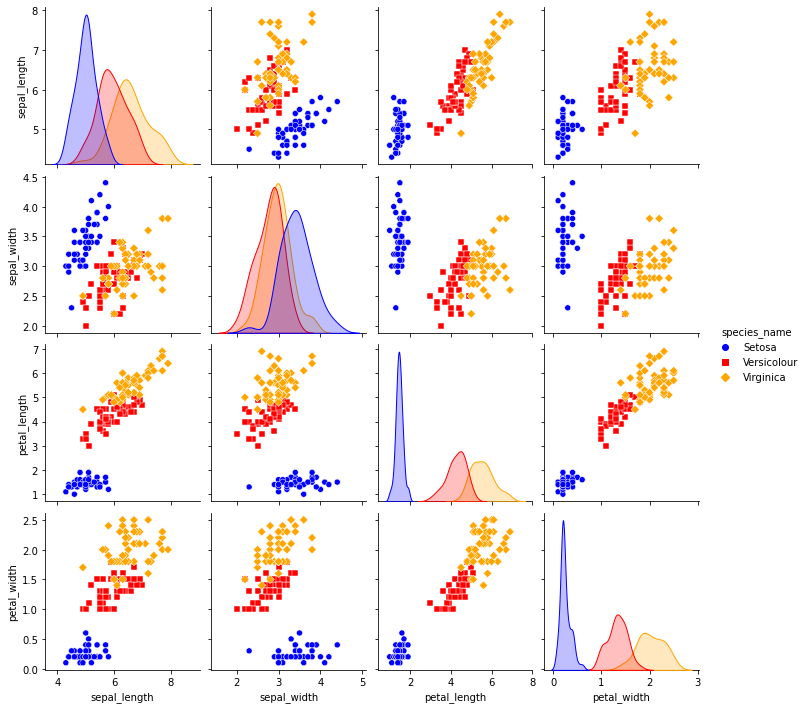

In [13]:
# Check for relationships between the features

sb.pairplot(df.drop(['species'],axis=1), hue='species_name', markers=["o", "s", "D"], 
             palette={'Setosa':'blue','Versicolour':'red','Virginica':'orange'})
# Significant differences are apparent between the features
# Setosa is most easily separated but Versicolour and Virginica do overlap slightly across all the features

<AxesSubplot:>

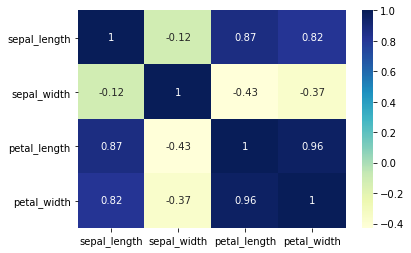

In [14]:
# Check for correlation between features

sb.heatmap(df.drop(['species'],axis=1).corr(), cmap="YlGnBu", annot=True)
# Each feature is highly correlated with the others except for Sepal width

### c. Create training and test data for model builds

- I have chosen a standard 70% and 30% split for training & test datasets respectively. As we have been asked not to use a cross-validation approach for model evaluation it is possible that my training data misses out on key information in the data leading to additional bias.
- Note that no standardization of the features has been undertaken as they are all defined by the sam units (cm)

In [15]:
# Define feature and target (species) data
X=df.drop(['species','species_name'],axis=1)
y=df['species']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)

print('Size of training cases  :',X_train.shape) 
print('Size of training classes:',y_train.shape) 
print('Size of test cases      :',X_test.shape) 
print('Size of test classes    :',y_test.shape) 

Size of training cases  : (105, 4)
Size of training classes: (105,)
Size of test cases      : (45, 4)
Size of test classes    : (45,)


In [17]:
# Check how the class priors differ from the full population
y_train.value_counts(dropna=False,normalize=True).sort_index()

0    0.304762
1    0.380952
2    0.314286
Name: species, dtype: float64

### d. Build model evaluation functions

In [31]:
# Confusion matrix function
def myConfMat(y_test, y_pred):  
    '''
    Returns a confusion matrix

            Parameters:
                    y_test (1D array): Array of actual label classifications
                    y_pred (1D array): Array of predicted label classifications

            Returns:
                    C1 (2D array)     : Confusion matrix
    '''     
    # Get count of unique classes
    classcount=len(np.unique(y_test)) 
    # Create an empty matrix of size classcount x classcount populated with zeros
    C=np.zeros([classcount,classcount])
    # Get data for actual and predicted classes
    y_test=list(y_test)
    y_pred=list(y_pred)
    # Populate each cell in confusion matrix 
    for i in range(len(y_test)):
        C[y_test[i],y_pred[i]]+=1
    # Enhance output of confusion matrix
    C1=pd.DataFrame(C)
    C1.rename(columns={0:'Pred-Setosa'}, index={0:'Act-Setosa'},inplace=True) 
    C1.rename(columns={1:'Pred-Versicolour'}, index={1:'Act-Versicolour'},inplace=True)
    C1.rename(columns={2:'Pred-Virginica'}, index={2:'Act-Virginica'},inplace=True) 
    return C1

# Evaluation metrics function
def eval(feat_data, clf, act, pred):  
    '''
    Returns standard model evaluation metrics of:
    
            Overall accuracy
            Precision, Recall, F1 score per class
            Confusion matrix

            Parameters:
                    feat_data (2D array)  : Dataframe of feature data
                    clf (model object)    : Type of model instantiation
                    act (1D array)        : Actual classes in provided data
                    pred (1D array)       : Predicted classes in provided data
    '''
    # Predict classes for test data using model
    y_pred = clf.predict(feat_data)
    # Get evaluation metrics
    accuracy = metrics.accuracy_score(act, pred)
    precision, recall, fscore,_=metrics.precision_recall_fscore_support(act, pred)
    print('overall accuracy=',accuracy)
    print('class precision =',precision)
    print('class recall    =',recall)
    print('class f1 score  =',fscore)
    print('confusion matrix:')
    print(myConfMat(act, pred))
    return

### e. Naïve Bayes classifier [2]

#### Build and evaluate model

In [19]:
# Instantiate a Bayes model with Gaussian observations
# With Naive Bayes we can enter the priors as per the full IRIS dataset
nb = naive_bayes.GaussianNB(priors=[0.33333,0.33333,0.33333])

# Fit model on training data
nb.fit(X_train, y_train)

# Predict classes for test data using model
y_pred_nb = nb.predict(X_test)

# Get evaluation metrics
eval(X_test, nb, y_test, y_pred_nb);

overall accuracy= 0.9555555555555556
class precision = [1.         0.83333333 1.        ]
class recall    = [1.         1.         0.88235294]
class f1 score  = [1.         0.90909091 0.9375    ]
confusion matrix:
                 Pred-Setosa  Pred-Versicolour  Pred-Virginica
Act-Setosa              18.0               0.0             0.0
Act-Versicolour          0.0              10.0             0.0
Act-Virginica            0.0               2.0            15.0


Good performance with only two misclassifications. However Naive Bayes assumes independence of features used to predict each class and we know from the correlation matrix above in (1)(b) above that sepal length, petal length and petal width are highly correlated. Considering uncorrelated features we can build a robust model using the different combinations of the uncorrelated features as below. Here we see that the best model comprises just two features of sepal width and petal_width and achieves the same performance metrics as per the model with all four features.

In [20]:
nb = naive_bayes.GaussianNB(priors=[0.33333,0.33333,0.33333])

for i in [['sepal_width','sepal_length'],['sepal_width','petal_length'],['sepal_width','petal_width']]:
    X_train1=X_train[i]
    X_test1=X_test[i]
    nb.fit(X_train1, y_train)
    y_pred_nb1 = nb.predict(X_test1)
    print("Model with feature:",i)
    eval(X_test1, nb, y_test, y_pred_nb1);
    print("")
    print("")

Model with feature: ['sepal_width', 'sepal_length']
overall accuracy= 0.8222222222222222
class precision = [0.94736842 0.5625     1.        ]
class recall    = [1.         0.9        0.58823529]
class f1 score  = [0.97297297 0.69230769 0.74074074]
confusion matrix:
                 Pred-Setosa  Pred-Versicolour  Pred-Virginica
Act-Setosa              18.0               0.0             0.0
Act-Versicolour          1.0               9.0             0.0
Act-Virginica            0.0               7.0            10.0


Model with feature: ['sepal_width', 'petal_length']
overall accuracy= 0.9333333333333333
class precision = [1.         0.76923077 1.        ]
class recall    = [1.         1.         0.82352941]
class f1 score  = [1.         0.86956522 0.90322581]
confusion matrix:
                 Pred-Setosa  Pred-Versicolour  Pred-Virginica
Act-Setosa              18.0               0.0             0.0
Act-Versicolour          0.0              10.0             0.0
Act-Virginica            

### f. Random Forest classifier [3]

#### Build and evaluate model

In [21]:
# Instantiate a Random Forest classifier model
rf = RandomForestClassifier(n_estimators=100,
                             max_features='sqrt',
                             criterion='gini',
                             max_depth=None,
                             bootstrap=True,
                             max_samples=0.75,
                             min_samples_split=2, 
                             random_state=0)

# Fit model on training data
rf.fit(X_train, y_train)

# Predict classes for test data using model
y_pred_rf = rf.predict(X_test)

# Get evaluation metrics
eval(X_test, rf, y_test, y_pred_rf);

overall accuracy= 0.9555555555555556
class precision = [1.         0.83333333 1.        ]
class recall    = [1.         1.         0.88235294]
class f1 score  = [1.         0.90909091 0.9375    ]
confusion matrix:
                 Pred-Setosa  Pred-Versicolour  Pred-Virginica
Act-Setosa              18.0               0.0             0.0
Act-Versicolour          0.0              10.0             0.0
Act-Virginica            0.0               2.0            15.0


Good performance again with only two misclassifications

#### Evaluate feature importance

- The scikit learn RandomForestClassifier attribute 'feature_importances_' provides the importance of each feature. 
- Each feature importance is calculated as the average impurity decrease computed from all decision trees in the forest (Kumar, 2020)
- In our data we can see from the table below that the petal width and petal length combined have an importance of 88% and so are the most importance features

In [22]:
feats = iris['feature_names']
importances = rf.feature_importances_
feature_importances = pd.DataFrame([(a, b) for a, b in zip(feats,importances)],columns=['Feature','Importance'])
table=feature_importances.sort_values(by='Importance', ascending=False)
table

,Feature,Importance
3,petal width (cm),0.455017
2,petal length (cm),0.418586
0,sepal length (cm),0.104077
1,sepal width (cm),0.022320


#### Visualise feature importance

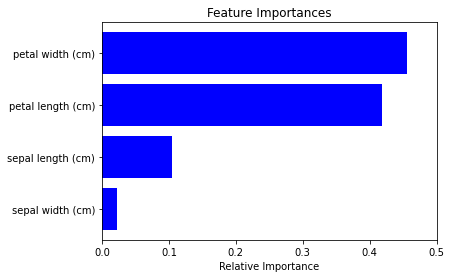

In [23]:
table1=table.sort_values(by='Importance',ascending=True)
plt.title('Feature Importances')
plt.barh(table1['Feature'],table1['Importance'], color='b', align='center')
plt.xticks([0,0.1,0.2,0.3,0.4,0.5])
plt.xlabel('Relative Importance')
plt.show()

We can also use SHAP values to understand the impact of each feature to a species:

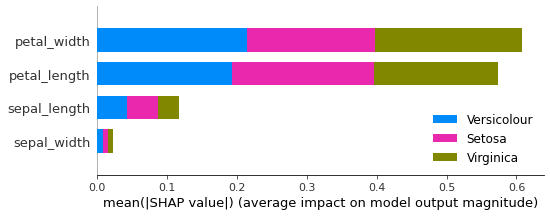

In [24]:
# Plot SHAP values

class_names = ['Setosa','Versicolour','Virginica']
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(df.drop(['species','species_name'],axis=1))
shap.summary_plot(shap_values, 
                  df.drop(['species','species_name'],axis=1).values, 
                  plot_type="bar", 
                  class_names=class_names, 
                  feature_names=df.drop(['species','species_name'],axis=1).columns)

The SHAP value plot also confirms that petal width and petal length are the most important features. But it also highlights that all the species use these two features differently based on the differing lengths of the SHAP values of each species in each feature. This differentiation contributes to the model having good discriminatory power.

### g. kNN classifier [2]

In [25]:
# Instantiate a KNN classifier model - retained the default no. of odd number of neighbours to avoid classification ties
knn=KNeighborsClassifier(n_neighbors=5, 
                         weights='uniform',
                         algorithm='brute',
                         p=2, 
                         metric='euclidean',
                         n_jobs=-1) 

# Fit model on training data
knn.fit(X_train, y_train)

# Predict classes for test data using model
y_pred_knn=knn.predict(X_test)

# Get evaluation metrics
eval(X_test, knn, y_test, y_pred_knn);     

overall accuracy= 0.9777777777777777
class precision = [1.         1.         0.94444444]
class recall    = [1.  0.9 1. ]
class f1 score  = [1.         0.94736842 0.97142857]
confusion matrix:
                 Pred-Setosa  Pred-Versicolour  Pred-Virginica
Act-Setosa              18.0               0.0             0.0
Act-Versicolour          0.0               9.0             1.0
Act-Virginica            0.0               0.0            17.0


Best performance with only one misclassification

## 2. Code report [6 marks total]

Key preliminary points:
- My classifiers were all instantiated on exactly the same training data so the results can be compared without concern of variation in the underlying training data across the three different classifiers. As the dataset is small with only 150 cases I chose a 70:30 split between training and test to ensure that the training is large enough to reflect the prior data population and to generalise well
- No grid search has been undertaken to find optimal parameters for each model as I believed this was outside the scope of the assignment
- All models built with scikit learn

Model builds:

- **Naive Bayes**: My first model calculates the probability of a test data point belonging to each class (species) given the four features. The class with highest probability score is associated to the data point. I have also supplied the prior probabilities so that the model can adjust its scores to reflect the make-up of the original population. The approach performed well with only two misclassifications but as noted in the EDA in (1)(b) three of the features are highly correlated so the independence assumption could be violated. So I ran the model again with only uncorrelated features and attained a model with exactly teh same performance metrics but with just two features.


- **Random Forest**: My ensemble model used the training data to build 100 trees from which a final classification can be made for each test data point[*]. Each tree was created by sampling the available data points (75%) and features (2) with replacement. Note the 2 features (=square root of all 4 features) was recommended by scikit learn for classification problems (scikit learn 2022). Expanding the number of trees did not increase performance. The gini criteria was used to measure the node purity at each step.  I expected this method to out-perform the other two as it can control over-fitting and bias but it misclassifies two test cases. This could be because it is only using two features at a time however the feature importance output showed only two key features drive class prediction.


- **kNN**: My model built on the training data finds the 5 nearest training data points to each test data point using Euclidean distance. It then classifies the test data point with the majority class (species) of the 5 neighbours. My approach uses some default values in my parameters, namely 'k'=5 training data neighbours which is a good balance in a small dataset to find the classification boundary which does not over/under fit and is also an odd value of k which will alleviate the issue of ties. 'Euclidean' metric was chosen as the data is continuous and more efficient that other metrics like Manhattan, the algorithm chosen is 'brute force' to consider every data point (as again the data is small). The results are the best of all 3 methods with only one misclassification so the classification boundary fits well with k=5.


[*] Rather than undertaking a vote for each test data point across all 100 trees scikit-learn implementation now combines classifiers by averaging their probabilistic prediction (scikit learn, 2022)


## 3. Model questions [14 marks total]

### 3.1 Naïves Bayes questions [4]

**Why do zero probabilities in our Naïve Bayes model cause problems?**

The Naives Bayes algorithm builds the model on the training data supplied and determines the posterior probability of each class (e.g. 'species' in the case of IRIS data) given the predictor features i.e. P(class='Seratosa'|x1,x2,...xn) for n features. Suppose one of our n IRIS features xi is a categorical feature e.g. soil type which takes values of A, B, C, D, E. If the training data only included data samples comprising the values of A, B, D, E for this feature for a particular class, the resultant model will set the posterior probability for the class to zero for the test data sample where E is present for that feature. This is because in the Naive Bayes formula P(x=E|class)=0 and thus the multiplication with all the other conditional probabilities will result in zero. This means that for any test samples being scored for this class, they will all have zero probability scores if they contain E for this feature. Conversely if a test instance does not contain an observation for a category of a categorical feature in the trained model then the conditional probability for the class will also multiply to zero.

**How can we avoid the problem of zero probabilities in our Naïve Bayes model?**

Two ways, firstly ensure the training data is representative of the population it is sampled from (e.g. stratified) in all its features and so when the model is built it will work effectively on any test data. Second for when a test data sample has an observation of zero for a category of a categorical feature we can employ a Laplace Estimator to it during the conditional probability calculation (for all classes). This is approach is also called 'smoothing' and naive_bayes.GaussianNB provides a parameter option to do this (scikit learn, 2022):

naive_bayes.GaussianNB(var_smoothing=1e-09) 

Note that the reason for using a Guassian approach is so that the conditional probabilities for continous features are determined using the Gaussian distribution formula which considers their respective means and variance. For categorical features they are calulated simply using observed counts in the usual manner. 

### 3.2 Random Forest questions [6]

**Which feature is the most important from your random forest classifier?**

Petal width and petal length have significantly highest feature importance scores. The exploratory data analysis above in (1)(b) shows that they are both highly correlated which results in both of them having similar importance scores (Dubey, 2018). Hence we can can just consider petal width as the most important feature of the two petal features.

**Can any features be removed to increase accuracy of the model, if so which features?**

Along with the finding above - removing of petal width - sepal width and sepal length have the lowest feature importance scores and so could be considered redundant. One way to find the minimum number of features with the highest accuracy score is by iteratively considering all combinations of the features using the same model parameters. Doing this with the code below I find my findings hold. Using just petal width provides the same level of accuracy as per using all four features. No improvement in score was attained using any smaller subset of the four features, that is, performance does not increase for removal of features.  

In [26]:
# Get all subsets (combinations) of features
feats=['petal_width','petal_length','sepal_length','sepal_width']
sets = [[]]
for feat in feats:
    sets += [set + [feat] for set in sets]
# Remove first element in list ('[]')
del sets[0]

In [27]:
# Fit the random forest model instantiated above to each subset of features and evaluate
perf={}
for i in range(0,len(sets)):
    rf.fit(X_train[sets[i]], y_train)
    y1_pred_rf=rf.predict(X_test[sets[i]])
    perf[i]=[metrics.accuracy_score(y_test, y1_pred_rf),len(sets[i]),sets[i]]
    #print('Accuracy:',metrics.accuracy_score(y1_test, y1_pred),'No. of features:',len(sets[i]),'Features used:',sets[i])  

In [28]:
# Check the performance of each feature subset
{k: v for k, v in sorted(perf.items(), key=lambda item: item[1], reverse=True)}

{14: [0.9555555555555556,
  4,
  ['petal_width', 'petal_length', 'sepal_length', 'sepal_width']],
 12: [0.9555555555555556, 3, ['petal_width', 'sepal_length', 'sepal_width']],
 10: [0.9555555555555556, 3, ['petal_width', 'petal_length', 'sepal_width']],
 8: [0.9555555555555556, 2, ['petal_width', 'sepal_width']],
 4: [0.9555555555555556, 2, ['petal_width', 'sepal_length']],
 2: [0.9555555555555556, 2, ['petal_width', 'petal_length']],
 0: [0.9555555555555556, 1, ['petal_width']],
 6: [0.9333333333333333, 3, ['petal_width', 'petal_length', 'sepal_length']],
 13: [0.9333333333333333, 3, ['petal_length', 'sepal_length', 'sepal_width']],
 9: [0.9333333333333333, 2, ['petal_length', 'sepal_width']],
 1: [0.9333333333333333, 1, ['petal_length']],
 5: [0.8888888888888888, 2, ['petal_length', 'sepal_length']],
 11: [0.8, 2, ['sepal_length', 'sepal_width']],
 3: [0.6888888888888889, 1, ['sepal_length']],
 7: [0.4888888888888889, 1, ['sepal_width']]}

**Explain why it would be useful to remove these features**

We could consider a model with only one feature (petal width) instead of four and attain the same level of accuracy. Removing the irrelevent features should decrease generalisation error and improve operational efficiency when considering model building and validation of bigger datasets. 

### 3.3 kNN questions [4]

**Do you think the kNN classifier is best suited to the Iris dataset?**

While the performance statistics above suggest that kNN is the best algorithm, I believe it is best suited to the Iris data in terms of algorithm and the qualities of the dataset.

Compared to the other two algorithms:

- Naive Bayes makes the assumption that each prediction feature is independent of each other in each class. This is quite an unrealistic assumption for the Iris data as we can see from above correlation table in (1)(b) that three of the features are highly correlated
- As the dataset is relatively small a Random Forest using bootstrapping will result in many of the same cases being used in each tree and combined with only two features being selected - as per my parameter settings - I could end up with very shallow trees and resulting in little feature interaction and poor model fitting. 

In regards to the dataset - while the answer to the next question validates its suitability - it lends well to kNN as: 

- The problem is a multiclass classification problem involving numeric-only data features
- The Iris dataset is small (only 150 cases) with few features so the curse of dimensionality is not a concern for distance calculation
- There are no outliers and little noise (cf. the exploratory data analysis in (1)(b) above) which may affect the classifications

**What ideal qualities would the most appropriate dataset display?**

Ideally for kNN the training dataset would:
- Comprise features with numeric values so that distances can be calculated
- Not have high feature dimensionality as this increases the complexity of the distance calculations
- Not be large in terms of number of data cases as kNN is a 'lazy' learner in respects that it needs to remember all training data cases to be able to calculate the respective pairwise distances for each test data case supplied
- Comprise features which are of the same scale (as per this Iris dataset) so that certain features do not dominate the distance calculation and influence the outcomes. This can however be fixed via normalisation/standardisation
- Not contain outliers and/or noise - which can become influential on smaller values of k 

## 4. Comparing models [18 marks total]

### 4.1 Compare each model [3]
**What differences do you see between your Naïve Bayes classifier, your random forest classifier, and your kNN classifier?** 

All of my models produce excellent results but the kNN model performs the best.

Performance-wise the kNN algorithm gives me the best overall accuracy of 97.8% versus 95.6% for Naive Bayes & Random Forest respectively with it only misclassifying one test case versus two test cases for the other methods (cf. confusion matrices of (2)(e),(f) & (g) above). 

Also as can seen below it performs best of all three models in terms of:

- Overall precision - ability to classify a test case as being of the species when it is actually not
- Overall recall - ability to classify a test case as per its actual species 
- Weighted average of F1 score - harmonic average of precision and recall between 0 and 1 with 1 being the best score 

As the training dataset cases are not balanced (Versicolour comprises 38.1% of cases compared to 31.4% for Virginica and 30.5% for Setosa) the F1 scores should be used to compare the models and not overall accuracy (Huilgol, 2019) so on this basis of the scores below the kNN classifer is the best model.

In [29]:
# Get summary of performance statistics

print('\033[1m' + 'Overall accuracy score     ','\033[0m',
      'NB:',round(metrics.accuracy_score(y_test, y_pred_nb1),2), # Revised model as per (3.1) above
      'RF:',round(metrics.accuracy_score(y_test, y1_pred_rf),2), # Revised model as per (3.2) above
      'kNN:',round(metrics.accuracy_score(y_test, y_pred_knn),2))
print('\033[1m' + 'Overall precision scores   ','\033[0m',
      'NB:',round(metrics.precision_score(y_test, y_pred_nb1, average='macro'),2), # Revised model as per (3.1) above
      'RF:',round(metrics.precision_score(y_test, y1_pred_rf, average='macro'),2), # Revised model as per (3.2) above
      'kNN:',round(metrics.precision_score(y_test, y_pred_knn, average='macro'),2))
print('\033[1m' + 'Overall recall scores      ','\033[0m',
      'NB:',round(metrics.recall_score(y_test, y_pred_nb1, average='macro'),2), # Revised model as per (3.1) above
      'RF:',round(metrics.recall_score(y_test, y1_pred_rf, average='macro'),2), # Revised model as per (3.2) above
      'kNN:',round(metrics.recall_score(y_test, y_pred_knn, average='macro'),2))
print('\033[1m' + 'Weighted average F1 scores ','\033[0m',
      'NB:',round(metrics.recall_score(y_test, y_pred_nb1, average='weighted'),2), # Revised model as per (3.1) above
      'RF:',round(metrics.recall_score(y_test, y1_pred_rf, average='weighted'),2), # Revised model as per (3.2) above
      'kNN:',round(metrics.recall_score(y_test, y_pred_knn, average='weighted'),2))

Overall accuracy score       NB: 0.96 RF: 0.96 kNN: 0.98
Overall precision scores     NB: 0.94 RF: 0.94 kNN: 0.98
Overall recall scores        NB: 0.96 RF: 0.96 kNN: 0.97
Weighted average F1 scores   NB: 0.96 RF: 0.96 kNN: 0.98


### 4.2 Accuracy [6]
**Can you explain why there are differences in accuracy between the three classifiers?**

My Naive Bayes and Random Forest models above performed the same so I propose to answer this question on how it is possible for the three classifiers to result in different levels of accuracy. 

There are many factors that can influence how an algorithm assigns a class (species) to each test data case, such as: 
  - difference in algorithm design
  - size of the training dataset (data cases and features)
  - sensitivity in terms of bias/variance
  - parameter optimisation 

For **Naive Bayes** two key considerations can impact its accuracy. Firstly, it is a probabilistic algorithm which assumes that the features used in each class (species) prediction are independent which can be an erraneous assumption for a lot of datasets resulting in unreliable probabilities and possibly can be inaccurate class assignments. Second, it is considered to be a high bias-low variance classifier because the model tends to underfit the data and does not generalise well meaning it can systematically predict the wrong classes with low variance in predictions overall.

Conversely a **Random forest** can create a model which has low bias and low variance thus improving in accuracy over other types of classifiers. While one decision tree is prone to overfitting and having low bias and high variance the bagging approach of a random forest can reduce the variance while leaving the bias unchanged (Zang and Yan, 2012). Moreover the tuning of some of its many hyperparameters can also be used to reduce accuracy error.

**kNN** is a lazy learner which memorizes the training data. When its parameter k is small there is a higher chance - due to high variance - for a new data case to have an incorrect class prediction as the model is more sensitive to the training data (Singh, 2018). For higher values of k the model provides better generalisation of new data cases with lower variance but higher bias occurs. So finding the optimal value of parameter k is key for accuracy in kNN.

### 4.3 Appropriate use [9]

**ANSWER**

While all three of the classifiers could be considered for the same use case I believe it is important to consider the pros and cons of each algorithm and the structure of the data to decide which one is most suitable (bias and variance considerations have been explained above already).

**Naive Bayes** is a fast algorithm which is mainly used for multi-class classification problems. There is evidence to suggest it does not work well for regression problems (EIBE et al, 1999). It works well with large datasets and sparse features hence it lends itself to text classification problems (Johnson-Laird, 2020) and is actually used in spam detection for the email services of Gmail, Yahoo! and Hotmail (Motwani, 2020). 

Its probabilistic approach works well with text classification - understanding the historical frequency of spam-type and non-spam-type words and using a bag of words approach to create the feature vectors. An example of such a dataset can be found here https://www.kaggle.com/datasets/balaka18/email-spam-classification-dataset-csv where around 5,000 emails comprising around 3,000 of the most common words are assigned as either 'spam' or 'non-spam'. Given this data structure the Naive Bayes algorithm can then be applied to a new email by calculating:

- Conditional probabilities of each word given a class ('spam' or 'non-spam') can be calculated, i.e. P('word i'|'spam' or P('word i'|'non-spam') 
- Prior class probabilities i.e. P('spam') or P('non-spam')
- Final posterior probabilities i.e. P('spam'|'word i', 'word j', ...., 'word n') or P('non-spam'|'word i', 'word j', ...., 'word n')
- The maximum of the posterior probabilities of the two classes classifies an email as 'spam' or 'non-spam'

Like most applications of Naive Bayes the feature independence assumption does not generally hold as certain words will tend to follow each other in an email. But this can be somewhat ameliorated by only keeping key highlighted after removing defined stop words. But regardless, most literature points to Naive Bayes being a good classifier that works well in practice, but the probabaility scores are not the most reliable.

The **k-nearest neighbours (kNN)** algorithm can be used for both classification and regression problems. It determines the 'similarity' of new datacases in the training data in terms of their N feature values and pairwise distances to the other datacases in the N-dimensional training space. Pros include: fast as no training time is required due to it simply memorizing the training data and its efficiency at imputation of missing values. Its cons however can impact on its use. For example it struggles to be efficient for large datasets (>50,000 data cases) and for those with many features due to the need to calculate pairwise distances (Goyal, 2021) and the need to standardize the data features. Hence it is not so good for text classification compared to other classifiers. Also, unlike for Random forests, feature importance cannot be determined meaning we cannot identify which features mostly drive the classifications (Kulkarni, 2020). 

A definitive real-life application of kNN is predicting possible voter outcomes in a Presidential election for 'undecided' (or 'swing') voters e.g. classifying voters as “vote Democrat” or “vote Republican” based on socio-demographics features of known voters in small towns. A good dataset to undertake such an analysis with kNN comes from the 'Show of Hands' data platform which comprises aspects of the lifestyles gained via questionnaires and their Presidential votes. This can be found at https://www.kaggle.com/competitions/can-we-predict-voting-outcomes/data and comprises both training and test data. Here the categorical features can be one hot encoded to become numeric and after standardization, all the pairwise distances can be calculated between each point in the test data and all points in the training data from which the classifier can then derive the k nearest neighbours and make assign the majority presidential candidate to the test datacase (assume k is odd).

A **Random forest** is a fast training black box ensemble method which like kNN can handle both classification and regression problems.  Through its bootstrapping of data case samples it can produce many decision trees in parallel which when used together generalise and reduce overfitting and variance. Random forests have been described as the 'Swiss Army Knife' of supervised models due to its many advantages such as: no assumptions of the data are required and hence it can handle non-linear data, no transformations required for categorical and numerical features, no feature standardization required, no validation dataset required as each tree is built on a sample of the data cases and so the remainder can be used for validation (a bonus for when dealing with smaller datasets), not susceptible to outliers (Bhalla, 2014) and can inform us of feature importance - a useful output even when a model is not required. More importantly, unlike for kNN, it works well on large datasets and those with many features. Considering all of this information, a good use case for a random forest is one where the data may be large and interpretabilty is not important, although we would like to understand feature importances. In my work at Sky I have used the random forest algorithm to build a customer churn model for a large dataset comprising circa 10,000,000 customers and 100s of features which consider a customer's product holdings, contract/discount offer statuses, socio-demographics, viewing behaviour and enagagement data with Sky e.g. telephone calls. The data is a mixture of categorical and numeric features and while many features are checked for collinearity/redundancy the random forest enabled me to create a good model which generalises well (after applying hyperparameter tuning). Here I was interested in the main drivers of churn so I could inform the business and also I wanted the probabilities scores so that I could create likelihood scores ('likelihood to churn' compared to the overall base probability score).

## 5. References

Bhalla, D. (2014), _A COMPLETE GUIDE TO RANDOM FOREST IN R_, available from https://www.listendata.com/2014/11/random-forest-with-r.html

Dubey, A. (2018), _Feature Selection Using Random forest_, available from https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f

EIBE, F. et al (1999), _Naive Bayes for Regression_, available from https://www.cs.waikato.ac.nz/~eibe/pubs/nbr.pdf

Goyal, C. (2021), _20 Questions to Test your Skills on KNN Algorithm_, available from https://www.analyticsvidhya.com/blog/2021/05/20-questions-to-test-your-skills-on-k-nearest-neighbour/

Huilgol, P. (2019), _Accuracy vs. F1 score_, available from https://medium.com/analytics-vidhya/accuracy-vs-f1-score-6258237beca2

Johnson-Laird, B. (2020), _Text classification with feature selection using Naive Bayes likelihoods_, available from https://towardsdatascience.com/nlp-with-naive-bayes-feature-selection-in-python-15c4d327aad5

Kulkarni, R. (2020), _Summary of KNN algorithm when used for classification_, available from https://medium.com/analytics-vidhya/summary-of-knn-algorithm-when-used-for-classification-4934a1040983

Kumar, A. (2020), _Feature Importance using Random Forest Classifier – Python_, available from https://vitalflux.com/feature-importance-random-forest-classifier-python/

Motwani, S. (2020), _Email Spam Filtering Using Naive Bayes Classifier_, available from https://in.springboard.com/blog/email-spam-filtering-using-naive-bayes-classifier/

scikit learn (2022), _1.11. Ensemble methods_, available from https://scikit-learn.org/stable/modules/ensemble.html#parameters

scikit learn (2022), _sklearn.naive_bayes.GaussianNB_, available at https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html?highlight=naive_bayes%20gaussiannb#sk

Singh, S. (2018), _Understanding the Bias-Variance Tradeoff_, available from https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229

Zhang, G. and Yan L. (2012), _Bias-corrected random forests in regression_, Journal of Applied Statistics Vol. 39, No. 1, January 2012, 151–160

## 6. Requirements file

In [30]:
!pip freeze > requirements.txt